In [63]:
#meta 8/29/2022 Introducing TensorFlow Similarity
# Example from blog post by Elie Bursztein and Owen Vallis, Google 20210913
#Refer to https://blog.tensorflow.org/2021/09/introducing-tensorflow-similarity.html

#infra: WGClouud
#kernel: pre-built TensorFlow 2 (local)
#$note: python 3.7.12 
# numpy 1.21.6
# tf2 2.9.1, tensorflow_similarity 0.16.7, tabulate 0.8.10


#history
# 8/29/2022 BUILD TF SIMILARITY MODEL WITH IMAGES
#      ds a sample from MNIST
#      $xtra: display an image with PIL
#      Since images are just an array of pixels carrying various color codes. NumPy can be used to convert an array into image.


#References
#TensorFlow Similarity Supervised Learning Hello World
# Refer to https://github.com/tensorflow/similarity/blob/master/examples/supervised_hello_world.ipynb

#Convert a NumPy array to an image  
# Refer to https://www.geeksforgeeks.org/convert-a-numpy-array-to-an-image/  


In [4]:
#$error: ModuleNotFoundError: No module named 'tabulate'
#$fix: inserted cell above
from tensorflow.keras import layers

try:
    # Embedding output layer with L2 norm
    from tensorflow_similarity.layers import MetricEmbedding 
    # Specialized metric loss
    from tensorflow_similarity.losses import MultiSimilarityLoss 
    # Sub classed keras Model with support for indexing
    from tensorflow_similarity.models import SimilarityModel
    # Data sampler that pulls datasets directly from tf dataset catalog
    from tensorflow_similarity.samplers import TFDatasetMultiShotMemorySampler
    # Nearest neighbor visualizer
    from tensorflow_similarity.visualization import viz_neigbors_imgs
except ModuleNotFoundError:
    #$note initially needed to install tf similarity
    #!pip install tensorflow_similarity
    !pip install tabulate
    
    # Embedding output layer with L2 norm
    from tensorflow_similarity.layers import MetricEmbedding 
    # Specialized metric loss
    from tensorflow_similarity.losses import MultiSimilarityLoss 
    # Sub classed keras Model with support for indexing
    from tensorflow_similarity.models import SimilarityModel
    # Data sampler that pulls datasets directly from tf dataset catalog
    from tensorflow_similarity.samplers import TFDatasetMultiShotMemorySampler
    # Nearest neighbor visualizer
    from tensorflow_similarity.visualization import viz_neigbors_imgs


Your CPU supports instructions that this binary was not compiled to use: SSE3 SSE4.1 SSE4.2 AVX AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib


In [58]:
#python version $my
import sys
print(sys.version)

3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0]


In [54]:
!pip show tensorflow

Name: tensorflow
Version: 2.9.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.7/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-serving-api, tensorflow-transform, tfx-bsl, witwidget


In [61]:
!pip show tensorflow_similarity

Name: tensorflow-similarity
Version: 0.16.7
Summary: Metric Learning for Humans
Home-page: https://github.com/tensorflow/similarity
Author: Tensorflow Similarity authors
Author-email: tf-similarity@google.com
License: Apache License 2.0
Location: /home/jupyter/.local/lib/python3.7/site-packages
Requires: bokeh, distinctipy, matplotlib, nmslib, numpy, pandas, Pillow, tabulate, tensorflow-datasets, tqdm, umap-learn
Required-by: 


# Introducing TensorFlow Similarity
Refer to https://blog.tensorflow.org/2021/09/introducing-tensorflow-similarity.html

<a href="https://github.com/tensorflow/similarity">TensorFlow Similarity</a> - a python package designed to make it easy and fast to train similarity models using TensorFlow.

## 0.Data


In [7]:
# Data sampler that generates balanced batches from MNIST dataset
from tensorflow_similarity.samplers import TFDatasetMultiShotMemorySampler
sampler = TFDatasetMultiShotMemorySampler(dataset_name='mnist', classes_per_batch=10)

2022-08-29 17:01:46.272371: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-08-29 17:01:46.272431: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-29 17:01:46.272494: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fbf47b419da0): /proc/driver/nvidia/version does not exist
2022-08-29 17:01:46.302254: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in 

converting train:   0%|          | 0/60000 [00:00<?, ?it/s]

converting test:   0%|          | 0/10000 [00:00<?, ?it/s]


The initial batch size is 20 (10 classes * 2 examples per class) with 0 augmenters


filtering examples:   0%|          | 0/70000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/70000 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/70000 [00:00<?, ?it/s]

### 0.1 View an Image

In [47]:
qx, qy = sampler.get_slice(3737, 1)

#myPreview
#qx class numpy.ndarray [of numpy.ndarrays], qy class numpy.ndarray
print(qx.shape, qy.shape) 
#qx[0] class numpy.ndarray, qy[0] numpy.int64
print(qx[0].shape, qy[0].shape)

#Reshape the above array to suitable dimensions
print(qx[0].reshape(28,28).shape)

(1, 28, 28, 1) (1,)
(28, 28, 1) ()
(28, 28)


In [48]:
from PIL import Image as im

# Create an image object from the above array using PIL library
data = im.fromarray(qx[0].reshape(28,28))
print(qy[0])
print(data.__class__)
data

# saving the final output as a PNG file
#data.save('image.png')

7
<class 'PIL.Image.Image'>


## 1. Data Prep
Data is already well pr
## 2. Model

In [8]:
# Build a Similarity model using standard Keras layers
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Rescaling(1/255)(inputs)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = MetricEmbedding(64)(x)

# Build a specialized Similarity model
model = SimilarityModel(inputs, outputs)

# Train Similarity model using contrastive loss
model.compile('adam', loss=MultiSimilarityLoss())
model.fit(sampler, epochs=5)

# Index 100 embedded MNIST examples to make them searchable
sx, sy = sampler.get_slice(0,100)
model.index(x=sx, y=sy, data=sx)


Distance metric automatically set to cosine use the distance arg to override.
Epoch 1/5
1000/1000 [==============================] - 24s 20ms/step - loss: 0.1394
Warmup complete
Epoch 2/5
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0534
Epoch 3/5
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0378
Epoch 4/5
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0322
Epoch 5/5
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0287
[Indexing 100 points]
|-Computing embeddings
4/4 [==============================] - 0s 6ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.



0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


## 3. Query Model

In [49]:
# Find the top 5 most similar indexed MNIST examples for a given example
qx, qy = sampler.get_slice(3737, 1)
nns = model.single_lookup(qx[0])

1/1 [==============================] - 0s 23ms/step


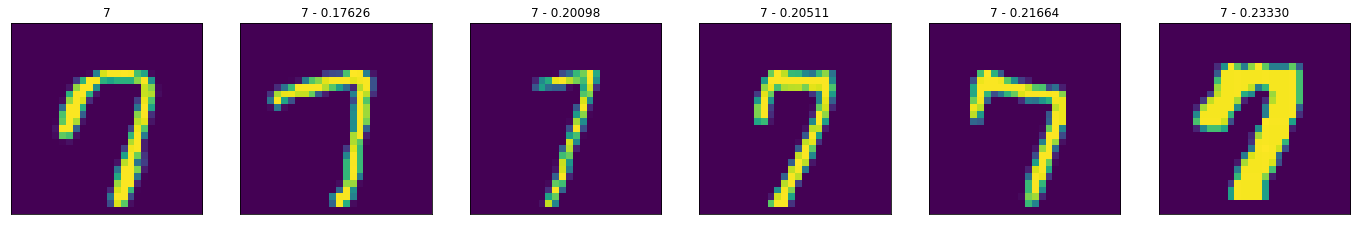

In [50]:
# Visualize the query example and its top 5 neighbors
viz_neigbors_imgs(qx[0], qy[0], nns)

## Xtra
### - MNIST and looking at an image
Refer to https://github.com/tensorflow/similarity/blob/master/examples/supervised_hello_world.ipynb

`Convert a NumPy array to an image`  
Refer to https://www.geeksforgeeks.org/convert-a-numpy-array-to-an-image/  
Since images are just an array of pixels carrying various color codes. NumPy can be used to convert an array into image.

In [52]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)

#load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

TensorFlow: 2.9.1


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [57]:
print(x_train[0].shape)
print(y_train[0])

#view an image example
from PIL import Image as im
# creating image object of above array
data = im.fromarray(x_train[0]) #class 'PIL.Image.Image'
data

# saving the final output as a PNG file
#data.save('image.png')

(28, 28)
5
